# comparing zooplankton tophic level (food-chain length) with the log10 pe ratio. 
* This is similar to a figure form pompei et al. 2022, trying to respond to one of the reviewers
* pe ratio is the ratio of NPP and export flux integrated over the year

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import numpy as np
import geoviews as gv
import holoviews as hv
import math
import hvplot.xarray
import xarray as xr
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import pylab 
from copy import deepcopy
import pandas as pd

# MatPlotlib
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import pylab
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.pyplot import figure
import matplotlib.gridspec as gridspec

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import seaborn as sns
import scipy.io as sio
import os
from scipy.stats import gaussian_kde

In [2]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [3]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## input file

In [4]:
### last 20 year climatology of the second cycle representing Jan 1990 - Dec 2009. 
newNCDFfiles = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim/clim_20yr_GNG595_*', recursive=True),
                      key=numericalSort)

In [5]:
ds = xr.open_mfdataset(newNCDFfiles,combine='by_coords')

## Calculate NPP integrated over the year

In [6]:
# MARBL SPECTRA NPP
total_npp_100m = ds.photoC_TOT_zint_100m/100 #mmol m-2 s-1
total_npp_100m = total_npp_100m.mean(dim='time') * (60*60*24*365) # mmol m-2 y-1

## Calculate export flux integrated over the year

In [7]:
export_flux_100m = ds.POC_FLUX_IN[:,10,:,:].mean(dim='time') * (60*60*24*365)/100 # mmol/m^2/y
#export_flux_100m = np.nanmean(export_flux_100m[10,:,:],axis=0)*10/100

In [8]:
export_flux_1000m = ds.POC_FLUX_IN[:,40,:,:].mean(dim='time') * (60*60*24*365)/100 # mmol/m^2/y
#export_flux_1000m = np.nanmean(export_flux_1000m[0:40,:,:],axis=0)

In [9]:
ds.z_t[0:40]/ds.z_t[40]

<xarray.DataArray 'z_t' (z_t: 40)>
array([0.00451996, 0.01355988, 0.02259981, 0.03163973, 0.04067965,
       0.04971957, 0.0587595 , 0.06779942, 0.07683934, 0.08587926,
       0.09491918, 0.10395911, 0.11299903, 0.12203895, 0.13107887,
       0.1401188 , 0.14924766, 0.15863168, 0.16840586, 0.17868336,
       0.18957746, 0.20120904, 0.21371174, 0.22723666, 0.2419573 ,
       0.258075  , 0.2758254 , 0.29548612, 0.31738576, 0.34191483,
       0.36953813, 0.40080997, 0.43639022, 0.47706202, 0.5237486 ,
       0.5775268 , 0.6396317 , 0.71144414, 0.7944512 , 0.8901664 ],
      dtype=float32)
Coordinates:
  * z_t      (z_t) float32 500.0 1500.0 2500.0 ... 78700.25 87882.52 98470.586

In [10]:
ds.z_t[40]/100

<xarray.DataArray 'z_t' ()>
array(1106.20421875)
Coordinates:
    z_t      float32 110620.42

In [11]:
pe_ratio = export_flux_100m/total_npp_100m

### Import zooplankton trophic level - a proxy for food-chain lenth

In [12]:
zoo_TL= np.load("/glade/u/home/gabyn/Notebook_scripts/Chapter2/Question_5/zoo_mean_TL.npy")

In [13]:
zoo_TL.shape

(12, 15, 384, 320)

Text(0.5, 1.0, 'Zoo TL')

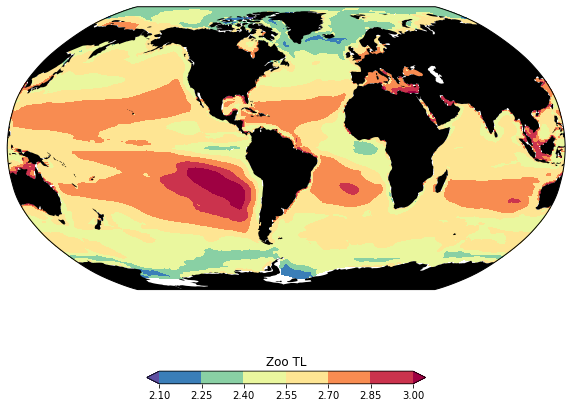

In [14]:
fig = plt.figure(figsize=(10, 10))
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(zoo_TL,axis=(0,1)))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',extend='both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('Zoo TL')

In [15]:
pe_ratio.shape

(384, 320)

In [16]:
TL_150m  = np.nanmean(zoo_TL,axis=(0,1))

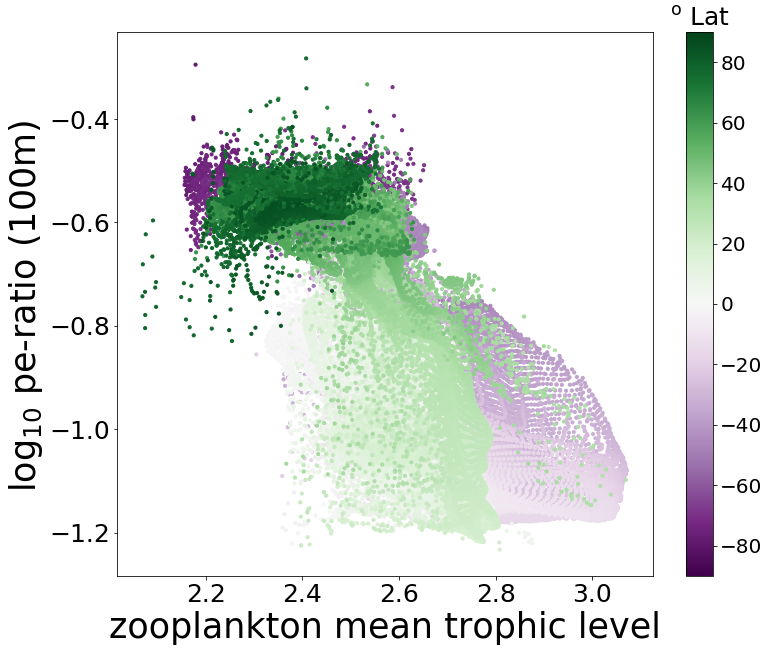

In [17]:
fig = plt.figure(figsize=(12, 10))
X=np.array(TL_150m)[~np.isnan(np.log10(np.array(pe_ratio)))]
Y=np.log10(np.array(pe_ratio))[~np.isnan(np.log10(np.array(pe_ratio)))]
lat = np.array(ds.TLAT)[~np.isnan(np.log10(np.array(pe_ratio)))]

z = lat
plt.scatter(y=Y,x=X, c=z,s=10, alpha=1,cmap='PRGn')
slope, intercept, r_value, p_value, std_err = stats.linregress(x=X,y=Y)
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('zooplankton mean trophic level', fontsize=35)
plt.ylabel('log$_{10}$ pe-ratio (100m) ',fontsize = 35)
#fig.text(0, 0.9, 'c',fontsize=35, fontweight='bold')
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)
cb.ax.set_title('$^o$ Lat',fontsize=25)
plt.clim(-90, 90) 
#fig.text(0.15, 0.84, 'y ='+'{0:1.3g}'.format(slope)+'x +'+'{0:1.3g}'.format(intercept)+'',fontsize=25)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/pe_ratio_zoo_tophic_level_100m_20yrclim.png',dpi=600, bbox_inches='tight')

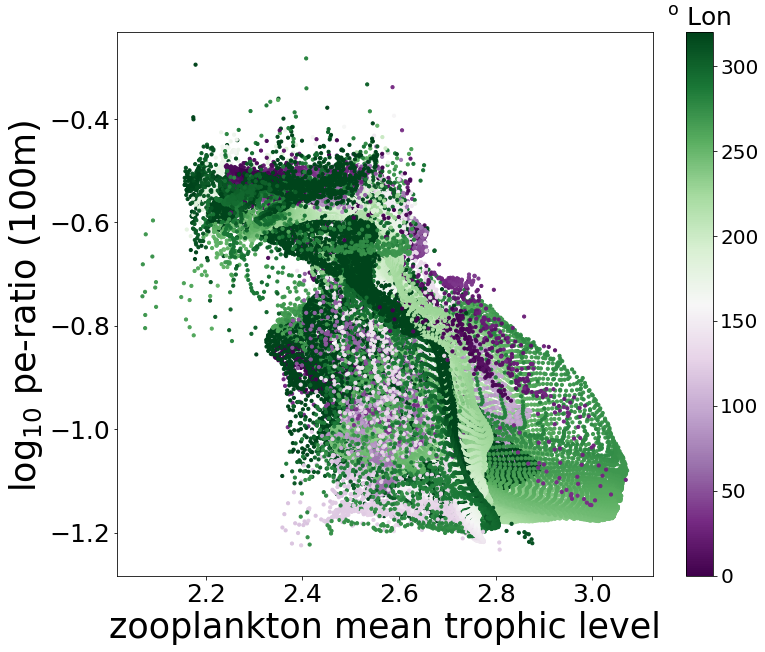

In [18]:
fig = plt.figure(figsize=(12, 10))
X=np.array(TL_150m)[~np.isnan(np.log10(np.array(pe_ratio)))]
Y=np.log10(np.array(pe_ratio))[~np.isnan(np.log10(np.array(pe_ratio)))]
lon = np.array(ds.TLONG)[~np.isnan(np.log10(np.array(pe_ratio)))]

z = lon
plt.scatter(y=Y,x=X, c=z,s=10, alpha=1,cmap='PRGn')
slope, intercept, r_value, p_value, std_err = stats.linregress(x=X,y=Y)
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('zooplankton mean trophic level', fontsize=35)
plt.ylabel('log$_{10}$ pe-ratio (100m) ',fontsize = 35)
#fig.text(0, 0.9, 'c',fontsize=35, fontweight='bold')
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)
cb.ax.set_title('$^o$ Lon',fontsize=25)
plt.clim(0, 320) 
#fig.text(0.15, 0.84, 'y ='+'{0:1.3g}'.format(slope)+'x +'+'{0:1.3g}'.format(intercept)+'',fontsize=25)
#fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/pe_ratio_zoo_tophic_level_100m_20yrclim_lon.png',dpi=600, bbox_inches='tight')